In [1]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import numpy as np
from StringIO import StringIO
import datetime as dt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)

Ishaan got the following dates from a query on the db:

```
===   beacondetectionsweek3  ===
min timestamp 2016-09-30 18:20:54.076000
max timestamp 2016-10-08 01:48:09.511000

===   beacondetectionsweek4  ===
min timestamp 2016-10-08 01:47:35.648000
max timestamp 2016-10-15 04:54:24.886000

===   beacondetections  ===
min timestamp 2016-11-05 18:52:21.240000
max timestamp 2016-12-02 01:34:45.775000

===   beacondetectionsweek1weekend  ===
min timestamp 2016-09-16 03:48:11.545000
max timestamp 2016-09-18 23:23:09.554000

===   beacondetectionsweek1to2  ===
min timestamp 2016-09-18 18:00:58.329000
max timestamp 2016-09-21 23:54:41.240000
```

I converted them into a dataframe and did some queries:

In [3]:
some_dates = [
["collection name", "start", "end"],
["beacondetectionsweek3", "30/09/2016", "8/10/2016"],
["beacondetectionsweek4", "8/10/2016", "15/10/2016"],
["beacondetections", "5/11/2016", "2/12/2016"],
["beacondetectionsweek1weekend", "16/09/2016", "18/09/2016"],
["beacondetectionsweek1to2", "18/09/2016", "21/09/2016"]
]

headers = some_dates.pop(0)

df = pd.DataFrame(some_dates, columns=headers)
df

,collection name,start,end
0,beacondetectionsweek3,30/09/2016,8/10/2016
1,beacondetectionsweek4,8/10/2016,15/10/2016
2,beacondetections,5/11/2016,2/12/2016
3,beacondetectionsweek1weekend,16/09/2016,18/09/2016
4,beacondetectionsweek1to2,18/09/2016,21/09/2016


It's hard to work directly with dates, so this converts them to epoch integers

In [4]:
tf = '%d/%m/%Y'

df["s"] = df.start.apply(lambda x: int(matplotlib.dates.date2num(dt.datetime.strptime(x, tf))))
df["e"] = df.end.apply(lambda x: int(matplotlib.dates.date2num(dt.datetime.strptime(x, tf))))
df.sort_values("s", inplace=True)
df.reset_index(drop=True, inplace=True)
df

,collection name,start,end,s,e
0,beacondetectionsweek1weekend,16/09/2016,18/09/2016,736223,736225
1,beacondetectionsweek1to2,18/09/2016,21/09/2016,736225,736228
2,beacondetectionsweek3,30/09/2016,8/10/2016,736237,736245
3,beacondetectionsweek4,8/10/2016,15/10/2016,736245,736252
4,beacondetections,5/11/2016,2/12/2016,736273,736300


If we plot the periods we can see which each collection contains and how much they overlap.

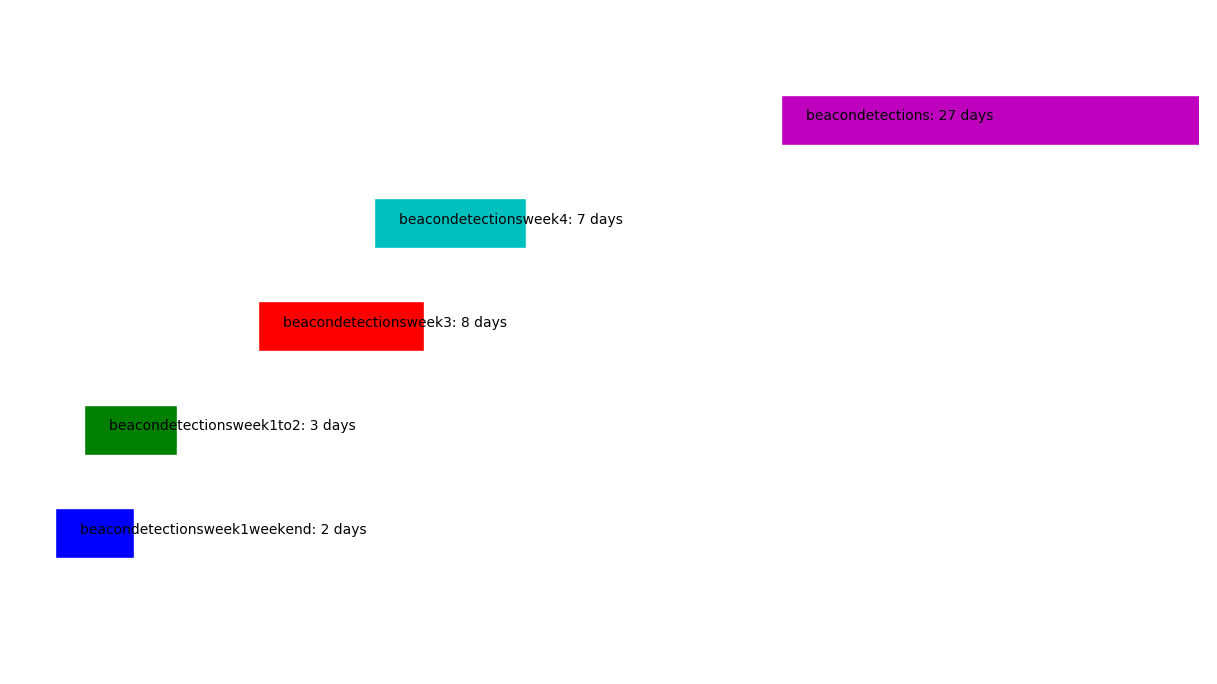

In [5]:
colours = ['b', 'g', 'r', 'c', 'm', 'y']
for index, row in df.iterrows():
    plt.plot([df.s[index], df.e[index]], 
             [index, index], 
             colours[index], lw=35)
    label = "{}: {} days".format(df["collection name"][index], df.e[index]- df.s[index])
    plt.text(df.s[index], index, label, fontsize=10)

plt.ylim(-1,5)
plt.axis('off')
plt.show()

The coloured bars show the _extent_ of the collections. They come from a min-max on the date field, so they don't show _how_ they intersect. Presumably they overlap because the base stations cached data until they got a good connection, perhaps some base stations were caching for 3-4 days until they'd fully caught up!

We'd like to see which collection is responsible for the training data. To see that, let's plot the training scans onto the same diagram.

Let's load up the scan data file:

In [6]:
dtypes = {"Unnamed: 0": int, "stickerID": int, "timeStamp": str, "person": str, "badge": str, "minor": int}
parse_dates = ["timeStamp"]
scans = pd.read_csv("allScanDetections.csv", 
                    dtype=dtypes,
                    parse_dates=parse_dates, 
                    date_parser=pd.datetools.to_datetime)
print scans.person.unique()
scans.head()

['yudi2' 'Tiara' 'daniel' 'Yudie' 'Julia' 'julia2' 'alicia' 'Zoheb' 'rick'
 'betsabe' 'blocker' 'aliasgher' 'michael' 'simon' 'taha' 'Hugh' 'aron'
 'mufaddal' 'arjun']


,Unnamed: 0,stickerID,timeStamp,person,badge,minor
0,0,68,2016-11-28 17:36:39,yudi2,NT,0
1,1,67,2016-11-28 17:36:30,yudi2,NT,0
2,2,77,2016-11-28 17:36:24,yudi2,NT,0
3,3,81,2016-11-28 17:36:20,yudi2,NT,0
4,4,77,2016-11-28 17:36:14,yudi2,NT,0


In [7]:
scans["d_num"] = scans.timeStamp.apply(lambda x: matplotlib.dates.date2num(x))

In [8]:
people = list(scans.person.unique())

In [9]:
scans["scanner_index"] = scans.person.apply(lambda x: people.index(x))
scans.head()

,Unnamed: 0,stickerID,timeStamp,person,badge,minor,d_num,scanner_index
0,0,68,2016-11-28 17:36:39,yudi2,NT,0,736296.733785,0
1,1,67,2016-11-28 17:36:30,yudi2,NT,0,736296.733681,0
2,2,77,2016-11-28 17:36:24,yudi2,NT,0,736296.733611,0
3,3,81,2016-11-28 17:36:20,yudi2,NT,0,736296.733565,0
4,4,77,2016-11-28 17:36:14,yudi2,NT,0,736296.733495,0


The blue dots on the right show the training scans.  To my great relief, they are completely contained by `beacondetections` so we know we have intersecting data. 

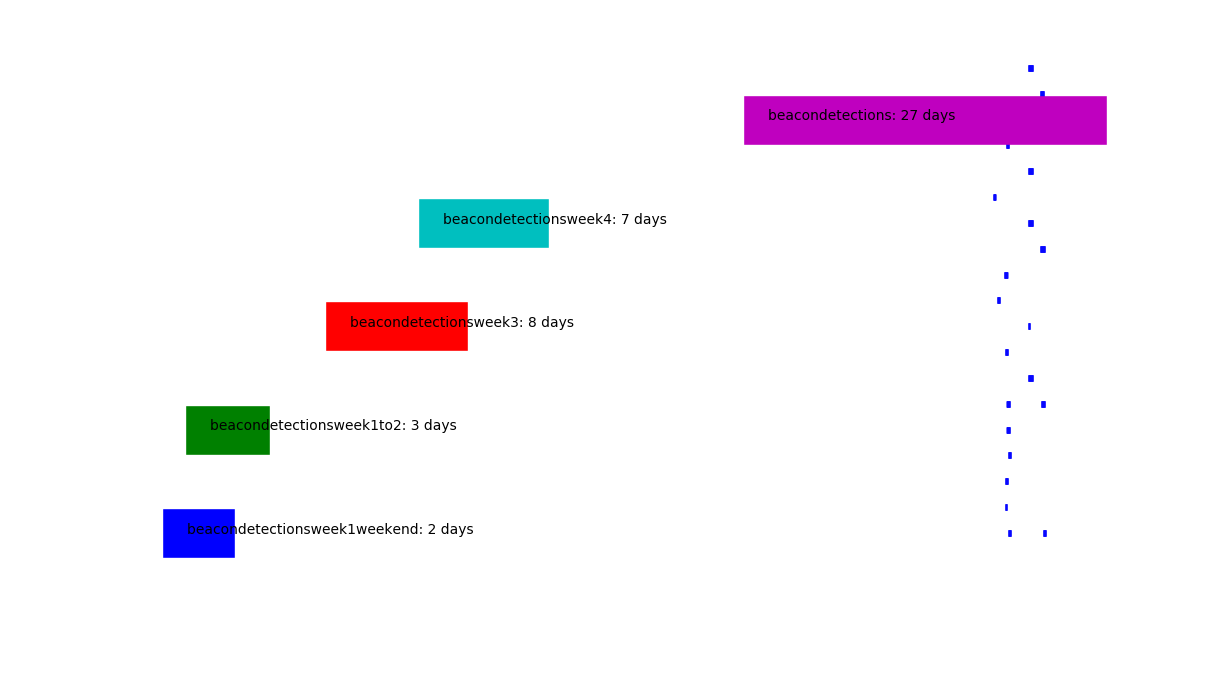

In [10]:
#plot the scans
plt.scatter(scans.d_num, scans.scanner_index/4, marker="|", alpha=0.1)

#plot the periods covered by each collection
for index, row in df.iterrows():
    plt.plot([df.s[index], df.e[index]], 
             [index, index], 
             colours[index], lw=35)
    label = "{}: {} days".format(df["collection name"][index], df.e[index]- df.s[index])
    plt.text(df.s[index], index, label, fontsize=10)

plt.ylim(-1,5)
plt.axis('off')

plt.show()

A violin plot would be the ideal thing to see when the ranges we're interested in are, but actually, there is so much white space it doesn't make much sense to look at.

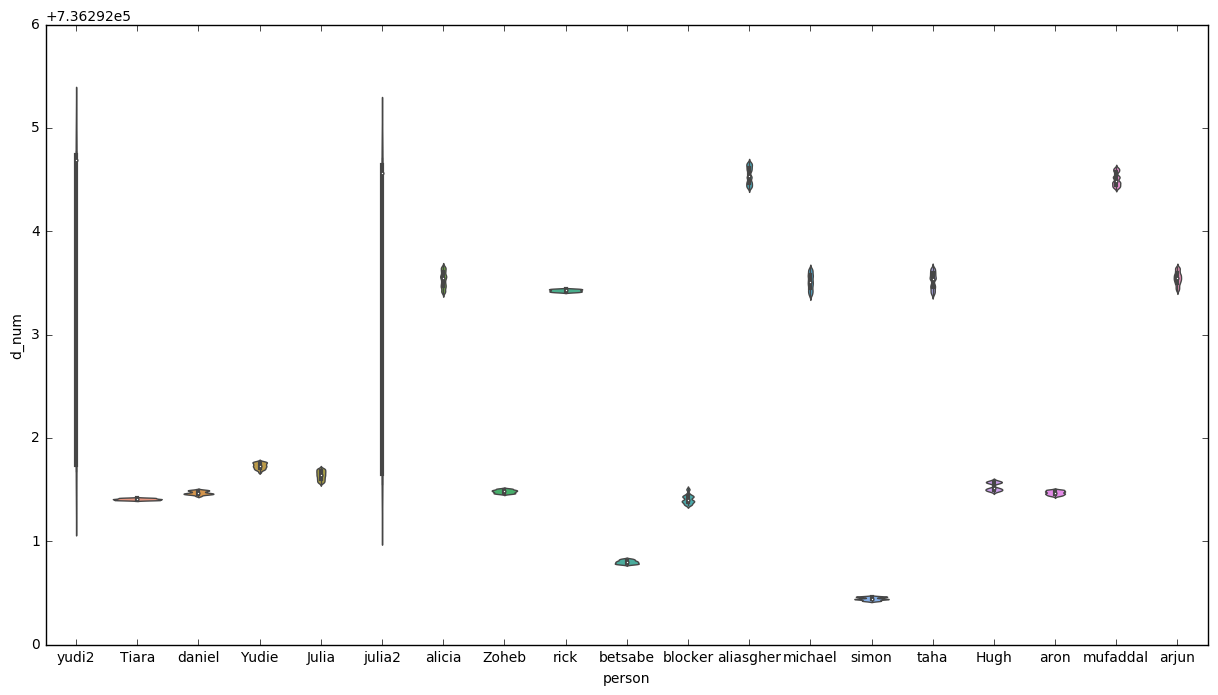

In [11]:
import seaborn as sns
sns.violinplot(x="person", y="d_num", data=scans)

A histogram makes a bit more sense, in an aggregate way. 

There's a bit of work here to make sure that I can read the axes to verify future results.

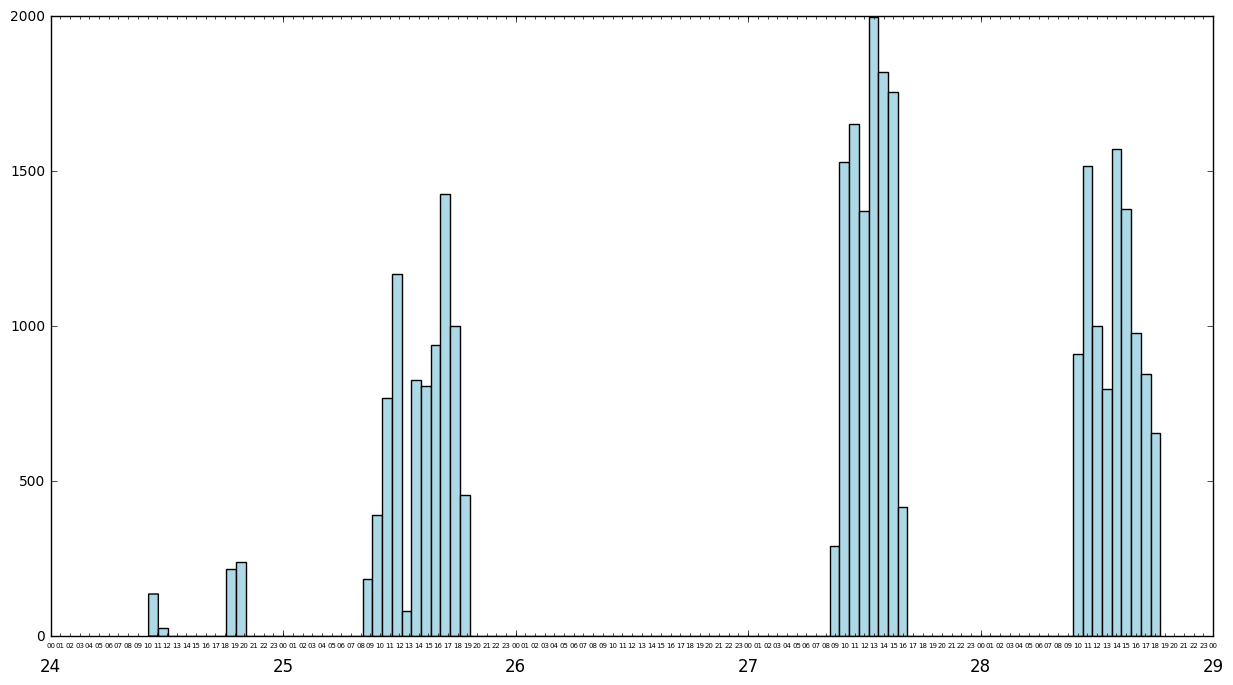

In [12]:
# plt.scatter(scans.d_num, scans.scanner_index)
fig, ax = plt.subplots(1,1)
(n, bins, patches) = ax.hist(scans.d_num, bins=104, color='lightblue')
# 104 bins gives close to an hour per bin (about 1h25s)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(matplotlib.dates.HourLocator())
ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%H'))
ax.get_xaxis().set_tick_params(which='major', pad=15)
ax.tick_params(axis='x', which='minor', labelsize=5)
ax.tick_params(axis='x', which='major', labelsize=12)
a = matplotlib.dates.num2date(bins[1]) - matplotlib.dates.num2date(bins[0]) 
# print a.total_seconds()/60/60
# print "n", len(n), n, "\n\nbins", len(bins), bins
plt.show()

We can get the histogram bins out of here. If we only keep the bins with scans in them then we can query only those time periods.

Once we have those periods, we can merge the contiguous ones.

In [13]:
periods = []
prev_bin_empty = True
for counter, bin_count in enumerate(n):
    if bin_count > 0:
        s = matplotlib.dates.num2date(bins[counter])
        e = matplotlib.dates.num2date(bins[counter+1])
        periods.append({
                "start": s,
                "end":   e,
                "count": bin_count
            }) 

periods

[{'count': 136.0,
  'end': datetime.datetime(2016, 11, 24, 11, 6, 49, 298074, tzinfo=<matplotlib.dates._UTC object at 0x7f3de3979d90>),
  'start': datetime.datetime(2016, 11, 24, 10, 6, 34, tzinfo=<matplotlib.dates._UTC object at 0x7f3de3979d90>)},
 {'count': 26.0,
  'end': datetime.datetime(2016, 11, 24, 12, 7, 4, 596158, tzinfo=<matplotlib.dates._UTC object at 0x7f3de3979d90>),
  'start': datetime.datetime(2016, 11, 24, 11, 6, 49, 298074, tzinfo=<matplotlib.dates._UTC object at 0x7f3de3979d90>)},
 {'count': 217.0,
  'end': datetime.datetime(2016, 11, 24, 19, 8, 51, 682689, tzinfo=<matplotlib.dates._UTC object at 0x7f3de3979d90>),
  'start': datetime.datetime(2016, 11, 24, 18, 8, 36, 384616, tzinfo=<matplotlib.dates._UTC object at 0x7f3de3979d90>)},
 {'count': 239.0,
  'end': datetime.datetime(2016, 11, 24, 20, 9, 6, 980772, tzinfo=<matplotlib.dates._UTC object at 0x7f3de3979d90>),
  'start': datetime.datetime(2016, 11, 24, 19, 8, 51, 682689, tzinfo=<matplotlib.dates._UTC object at 0x

In [14]:
p=periods
bigP = [p[0]]

for i in range(len(p)):
    if i>0:
        if p[i]["start"]==bigP[len(bigP)-1]["end"]:
#             print "is"
            bigP[len(bigP)-1]["end"] = p[i]["end"]
            bigP[len(bigP)-1]["count"] += p[i]["count"]
        else:
#             print "isn't"
            bigP.append(p[i])
            
# bigP

In [15]:
length_of_ranges = [(x["end"]-x["start"]).total_seconds()/60/60 for x in bigP]
print length_of_ranges
print dt.timedelta(hours=sum(length_of_ranges)), "rather than", (matplotlib.dates.num2date(max(bins))-matplotlib.dates.num2date(min(bins)))

[2.008498932777778, 2.008498932222222, 11.046744125833333, 8.03399572611111, 9.038245192222222]
1 day, 8:08:09.538473 rather than 4 days, 8:26:31


This means that we're only looking at pulling about 30 hours of data, not four and a bit days.

This is what the mongoDB query might look like:

In [17]:
print "\"$or\": ["
dq = '''    {{ "date": {{
       "$gte": new Date("{0}"), 
       "$lt": new Date("{1}")
    }}}},'''
for x in bigP:
    print dq.format(x["start"].isoformat(), 
                    x["end"  ].isoformat())

"$or": [
    { "date": {
       "$gte": new Date("2016-11-24T10:06:34+00:00"), 
       "$lt": new Date("2016-11-24T12:07:04.596158+00:00")
    }},
    { "date": {
       "$gte": new Date("2016-11-24T18:08:36.384616+00:00"), 
       "$lt": new Date("2016-11-24T20:09:06.980772+00:00")
    }},
    { "date": {
       "$gte": new Date("2016-11-25T08:12:10.557688+00:00"), 
       "$lt": new Date("2016-11-25T19:14:58.836541+00:00")
    }},
    { "date": {
       "$gte": new Date("2016-11-27T08:24:24.865383+00:00"), 
       "$lt": new Date("2016-11-27T16:26:27.249997+00:00")
    }},
    { "date": {
       "$gte": new Date("2016-11-28T09:30:47.317308+00:00"), 
       "$lt": new Date("2016-11-28T18:33:05+00:00")
    }},
